In [17]:
import torch
from torch import nn
from pathlib import Path
import zipfile
import shutil
import os
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from ipynb.fs.defs.FashionMNIST import *
from torchmetrics import Accuracy, ConfusionMatrix
import torchinfo
from torchinfo import summary


## Get data

In [2]:
data_path = Path('Foodvision_data')
data_path.mkdir(exist_ok=True,
                parents=True)

shutil.copy('/Users/navalmor/Desktop/pytorch/Food_images_classification/data/pizza_steak_sushi.zip',
            '/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data')

with zipfile.ZipFile('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi.zip', 'r') as z:
    z.extractall('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi')

In [3]:
def get_data(dir):
    for dir_path, dir_name, file_name in os.walk(dir):
        print(f"There are {len(dir_name)} directories {dir_name} and {len(file_name)} images in {dir_path}")
        #print(f"{dir_path} | {dir_name} | {file_name}")

get_data(data_path)

There are 1 directories ['pizza_steak_sushi'] and 2 images in Foodvision_data
There are 2 directories ['test', 'train'] and 0 images in Foodvision_data/pizza_steak_sushi
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_data/pizza_steak_sushi/test
There are 0 directories [] and 19 images in Foodvision_data/pizza_steak_sushi/test/steak
There are 0 directories [] and 31 images in Foodvision_data/pizza_steak_sushi/test/sushi
There are 0 directories [] and 25 images in Foodvision_data/pizza_steak_sushi/test/pizza
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_data/pizza_steak_sushi/train
There are 0 directories [] and 75 images in Foodvision_data/pizza_steak_sushi/train/steak
There are 0 directories [] and 72 images in Foodvision_data/pizza_steak_sushi/train/sushi
There are 0 directories [] and 78 images in Foodvision_data/pizza_steak_sushi/train/pizza


## Plot image

Image path: Foodvision_data/pizza_steak_sushi/train/steak/1264154.jpg
Image label: steak
Image width: 512
Image height:289


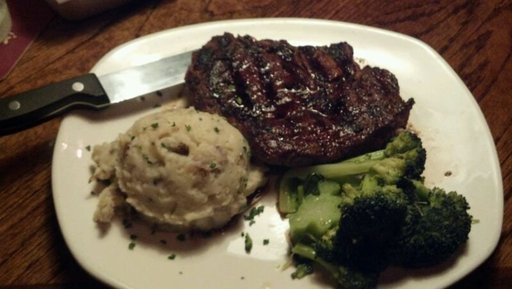

In [4]:
image_path = data_path/'pizza_steak_sushi'
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Image path: {random_image_path}")
print(f"Image label: {image_class}")
print(f"Image width: {img.width}\nImage height:{img.height}")
img

## Transform data

/opt/homebrew/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


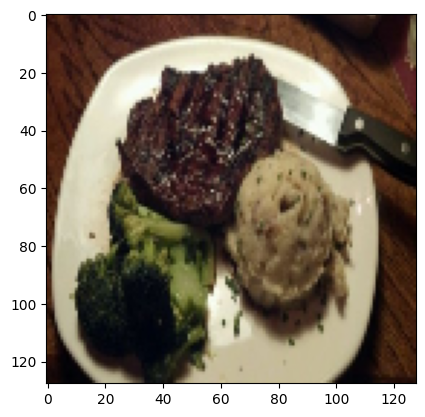

In [5]:
transformed_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)    
])

plt.imshow(transformed_data(img).permute(1,2,0))

## Load train/test data

In [6]:
train_data = datasets.ImageFolder(root=data_path/'pizza_steak_sushi/train',
                                    transform=transformed_data,
                                    target_transform=None)
test_data = datasets.ImageFolder(root=data_path/'pizza_steak_sushi/test',
                                   transform=transformed_data,
                                   target_transform=None)
len(test_data)

75

## Create dataloader

In [7]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=25,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=25,
                             shuffle=True)

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([25, 3, 128, 128])

## Build model

In [9]:
class FoodVisionModel(nn.Module):
    def __init__(self,
                 in_features :int,
                 hidden_units :int,
                 out_features :int):
        super().__init__()

        self.conv_stack_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_features,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_stack_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_stack_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*1024,
                      out_features=out_features)
        )

    def forward(self, X :torch.Tensor):
        #print(X.shape)
        X = self.conv_stack_1(X)
        #print(X.shape)
        X = self.conv_stack_2(X)
        #print(X.shape)
        #X = self.conv_stack_3(X)
        #print(X.shape)
        X = self.linear_classifier(X)
        #print(X.shape)
        return(X)


In [10]:
model = FoodVisionModel(3,20,len(train_data.classes))

In [40]:
model(train_data[0][0].unsqueeze(0))

tensor([[  9.0739, -17.1494,   2.6810]], grad_fn=<AddmmBackward0>)

In [12]:
5120/20

256.0

## Define train/eval function

In [48]:
torch.manual_seed(42)

def train_model(model :torch.nn.Module,
                train_dataloader :DataLoader,
                loss_fn :nn.functional,
                acc_fn :nn.functional,
                optimizer :torch.optim):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in train_dataloader:
        train_logits = model(X)
        train_loss += loss_fn(train_logits, y)
        train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc*100


def eval_model(model :nn.Module,
               test_dataloader :DataLoader,
               loss_fn :nn.functional,
               acc_fn :nn.functional):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc*100

## Run train/test loop

In [13]:
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass',
                  num_classes=3)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
epochs = 200
epoch_values = []
train_loss_values = []
test_loss_values = []
for epoch in range(epochs):
    train_loss, train_acc = train_model(model=model,
                                        train_dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        optimizer=optimizer)
    test_loss, test_acc = eval_model(model=model,
                                     test_dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     acc_fn=acc_fn)
    if epoch%1==0:
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | test_acc : {test_acc :.2f}%")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

Epoch : 0 | Train_loss : 1.097 | Train_acc : 43.11% | Test_loss : 1.190 | test_acc : 33.33%
Epoch : 1 | Train_loss : 1.105 | Train_acc : 35.11% | Test_loss : 1.126 | test_acc : 40.00%
Epoch : 2 | Train_loss : 1.079 | Train_acc : 45.78% | Test_loss : 1.033 | test_acc : 40.00%
Epoch : 3 | Train_loss : 0.951 | Train_acc : 52.44% | Test_loss : 1.152 | test_acc : 37.33%
Epoch : 4 | Train_loss : 0.970 | Train_acc : 52.00% | Test_loss : 1.073 | test_acc : 41.33%
Epoch : 5 | Train_loss : 0.882 | Train_acc : 60.44% | Test_loss : 1.085 | test_acc : 41.33%
Epoch : 6 | Train_loss : 0.902 | Train_acc : 53.78% | Test_loss : 1.051 | test_acc : 42.67%
Epoch : 7 | Train_loss : 0.874 | Train_acc : 54.67% | Test_loss : 1.032 | test_acc : 40.00%
Epoch : 8 | Train_loss : 0.821 | Train_acc : 63.11% | Test_loss : 1.093 | test_acc : 37.33%
Epoch : 9 | Train_loss : 0.819 | Train_acc : 62.22% | Test_loss : 1.104 | test_acc : 41.33%
Epoch : 10 | Train_loss : 0.814 | Train_acc : 62.22% | Test_loss : 1.067 | test_

## Plot train/test loss

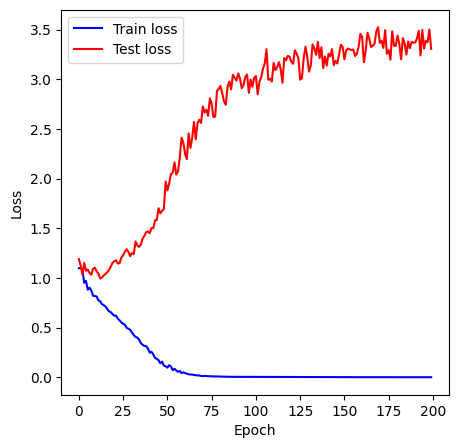

In [51]:
with torch.inference_mode():
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
    plt.plot(epoch_values, test_loss_values, c='r', label='Test loss')
    plt.legend()

## Plot confusion metrics

In [52]:
def make_pred(model :nn.Module,
              data :torch.Tensor):
    pred = []
    for X, y in data:
        logit = model(X.unsqueeze(dim=0))
        prediction = logit.argmax()
        pred.append(prediction.item())
    return pred

test_pred = make_pred(model, test_data)

/opt/homebrew/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [53]:
confusion_matrics = ConfusionMatrix(task='multiclass',
                                    num_classes=len(train_data.classes))
confusion_matrics_tensor = confusion_matrics(preds=torch.Tensor(test_pred),
                                             target=torch.Tensor(test_data.targets))
confusion_matrics_tensor

tensor([[16,  4,  5],
        [ 4,  9,  6],
        [15,  5, 11]])

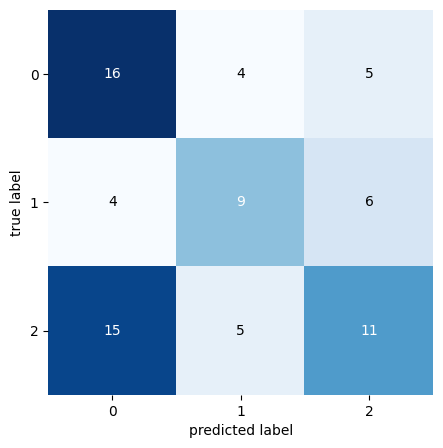

In [54]:
figure, axis = plot_confusion_matrix(
    confusion_matrics_tensor.numpy(),
    test_data.classes,
    figsize=(5,5)
)

In [55]:
summary(model, input_data=train_data[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
FoodVisionModel                          [1, 3]                    7,240
├─Sequential: 1-1                        [1, 20, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 20, 128, 128]         560
│    └─Tanh: 2-2                         [1, 20, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 20, 128, 128]         3,620
│    └─Tanh: 2-4                         [1, 20, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 20, 64, 64]           --
├─Sequential: 1-2                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 20, 64, 64]           3,620
│    └─Tanh: 2-7                         [1, 20, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 20, 64, 64]           3,620
│    └─Tanh: 2-9                         [1, 20, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 20, 32, 32]           --
├─

In [47]:
torch.save(model, '/Users/navalmor/Desktop/PyTorch_Learning/computer vision/models/FoodvisionModel.pt')